#**Практическое задание 8**

## Задание 1

In [2]:
!apt-get install -y libomp-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libllvm14 libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libllvm14 libomp-14-dev libomp-dev libomp5-14
0 upgraded, 4 newly installed, 0 to remove and 2 not upgraded.
Need to get 24.7 MB of archives.
After this operation, 118 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libllvm14 amd64 1:14.0.0-1ubuntu1.1 [24.0 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 24.7 MB in 1s (17.2 MB/s)
Selecting previously unselected package li

In [3]:
%%writefile openmp_array.cpp
#include <iostream>     // Библиотека для вывода текста в консоль (cout)
#include <vector>       // Библиотека для работы с динамическими массивами (vector)
#include <omp.h>        // Библиотека OpenMP для параллельных вычислений и таймера

using namespace std;    // Чтобы не писать std:: перед cout, vector и т.д.

int main() {

    // Размер массива данных (1 миллион элементов)
    const int N = 1'000'000;

    // Создаем массив data размера N, заполненный значением 1.0
    vector<double> data(N, 1.0);

    // Запоминаем время начала выполнения обработки
    double start_time = omp_get_wtime();

    // Параллельная обработка массива с использованием OpenMP
    // Каждая итерация цикла будет распределена между потоками CPU
    #pragma omp parallel for
    for (int i = 0; i < N; i++) {

        // Умножаем каждый элемент массива на 2
        data[i] *= 2.0;
    }

    // Запоминаем время окончания выполнения обработки
    double end_time = omp_get_wtime();

    // Проверяем корректность: выводим первый элемент массива
    cout << "First element: " << data[0] << endl;

    // Проверяем корректность: выводим последний элемент массива
    cout << "Last element: " << data[N - 1] << endl;

    // Вычисляем и выводим время выполнения обработки массива
    cout << "Execution time (seconds): "
         << end_time - start_time << endl;

    // Завершаем программу успешно
    return 0;
}

Overwriting openmp_array.cpp


In [4]:
!g++ -fopenmp openmp_array.cpp -O2 -o openmp_array
!./openmp_array

First element: 2
Last element: 2
Execution time (seconds): 0.000949189


## **Вывод**

В ходе выполнения задания была реализована обработка массива размером N=1000000 на CPU с использованием технологии OpenMP. Массив был инициализирован одинаковыми значениями 1.0, чтобы упростить проверку корректности вычислений: после умножения каждый элемент должен стать равным 2.0. Обработка выполнялась в параллельном цикле, что подтвердилось корректными значениями первого и последнего элементов массива. Время выполнения составило примерно 0.00095 секунды, что демонстрирует высокую эффективность параллельных вычислений. Использование OpenMP позволяет существенно ускорить выполнение операций над большими массивами за счёт распределения нагрузки между потоками процессора.

## Задание 2

In [1]:
!nvidia-smi

Sat Jan 24 17:03:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%%writefile cuda_array.cu
#include <iostream>                 // Для вывода в консоль (cout)
#include <vector>                   // Для std::vector (массив на CPU)
#include <cuda_runtime.h>           // Основные CUDA функции: cudaMalloc, cudaMemcpy, cudaEvent...
#include <device_launch_parameters.h> // Для CUDA-специфичных параметров запуска

using namespace std;                // Чтобы не писать std:: перед cout/vector

// CUDA-ядро (kernel): выполняется на GPU
// __global__ означает: функцию вызывает CPU, а выполняется она на GPU
__global__ void multiplyByTwo(double* d_data, int N) {

    // Считаем глобальный индекс элемента (какой элемент массива обрабатывает данный поток)
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Проверяем границы, чтобы не выйти за массив
    if (idx < N) {
        // Умножаем конкретный элемент на 2
        d_data[idx] *= 2.0;
    }
}

int main() {

    // Размер массива (1 миллион элементов)
    const int N = 1'000'000;

    // Размер памяти в байтах (сколько нужно места под N элементов типа double)
    size_t bytes = N * sizeof(double);

    // Создаём массив на CPU и заполняем его единицами (для простой проверки результата)
    vector<double> h_data(N, 1.0);

    // Указатель на память на GPU (device)
    double* d_data = nullptr;

    // Выделяем память на GPU под массив
    cudaMalloc((void**)&d_data, bytes);

    // Таймеры CUDA
    // События CUDA для измерения времени (очень точный GPU timing)
    cudaEvent_t start_total, stop_total;      // Общее время: H2D + kernel + D2H
    cudaEvent_t start_kernel, stop_kernel;    // Только ядро (kernel)

    // Создаём события
    cudaEventCreate(&start_total);
    cudaEventCreate(&stop_total);
    cudaEventCreate(&start_kernel);
    cudaEventCreate(&stop_kernel);

    // Запускаем измерение общего времени
    cudaEventRecord(start_total, 0);

    // Копируем данные CPU -> GPU (Host to Device, H2D)
    cudaMemcpy(d_data, h_data.data(), bytes, cudaMemcpyHostToDevice);

    // Настройка запуска ядра
    // Количество потоков в одном блоке (часто берут 256 или 512)
    int threadsPerBlock = 256;

    // Количество блоков: чтобы покрыть N элементов
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    // Замер времени только ядра
    cudaEventRecord(start_kernel, 0);

    // Запуск CUDA-ядра на GPU
    multiplyByTwo<<<blocksPerGrid, threadsPerBlock>>>(d_data, N);

    // Ждём, пока GPU закончит выполнение ядра (иначе таймер остановится слишком рано)
    cudaDeviceSynchronize();

    // Останавливаем замер времени ядра
    cudaEventRecord(stop_kernel, 0);
    cudaEventSynchronize(stop_kernel);

    // Копируем результат обратно GPU -> CPU (Device to Host, D2H)
    cudaMemcpy(h_data.data(), d_data, bytes, cudaMemcpyDeviceToHost);

    // Останавливаем замер общего времени (H2D + kernel + D2H)
    cudaEventRecord(stop_total, 0);
    cudaEventSynchronize(stop_total);

    // Получаем времена
    float kernel_ms = 0.0f;  // Время только ядра (миллисекунды)
    float total_ms = 0.0f;   // Время всего процесса (миллисекунды)

    // Вычисляем длительность между start_kernel и stop_kernel
    cudaEventElapsedTime(&kernel_ms, start_kernel, stop_kernel);

    // Вычисляем длительность между start_total и stop_total
    cudaEventElapsedTime(&total_ms, start_total, stop_total);

    // Проверка корректности
    // Выводим первый и последний элементы (должны стать 2.0)
    cout << "First element: " << h_data[0] << endl;
    cout << "Last element: " << h_data[N - 1] << endl;

    // Вывод времени выполнения
    cout << "Kernel time (ms): " << kernel_ms << endl;               // Только вычисление на GPU
    cout << "Total GPU time (ms): " << total_ms << endl;             // С учётом копирований
    cout << "Total GPU time (seconds): " << total_ms / 1000.0f << endl;

    // Очистка памяти
    // Освобождаем память на GPU
    cudaFree(d_data);

    // Удаляем CUDA-события
    cudaEventDestroy(start_total);
    cudaEventDestroy(stop_total);
    cudaEventDestroy(start_kernel);
    cudaEventDestroy(stop_kernel);

    // Успешное завершение программы
    return 0;
}

Writing cuda_array.cu


In [5]:
!nvcc cuda_array.cu -O2 -arch=sm_75 -o cuda_array
!./cuda_array

First element: 2
Last element: 2
Kernel time (ms): 0.11568
Total GPU time (ms): 4.08067
Total GPU time (seconds): 0.00408067


## **Вывод**

В ходе выполнения задания была реализована обработка массива размером N=1000000 на GPU с использованием технологии CUDA. Массив данных был скопирован на графический процессор, после чего CUDA-ядро выполнило умножение каждого элемента на 2. Корректность выполнения операции подтверждается тем, что первый и последний элементы массива после обработки стали равны 2.0.

Время выполнения вычислений непосредственно на GPU составило около 0.116 мс, что демонстрирует очень высокую скорость параллельной обработки данных на графическом процессоре. Общее время выполнения составило примерно 4.08 мс, поскольку оно включает дополнительные затраты на копирование данных между CPU и GPU.

Полученные результаты показывают, что GPU особенно эффективно выполняет вычислительные операции над большими массивами данных, однако при работе с такими задачами важно учитывать влияние времени передачи данных, которое может занимать большую часть общего времени выполнения.

## Задание 3

In [10]:
%%writefile hybrid_array.cu
#include <iostream>                      // cout, endl
#include <omp.h>                         // OpenMP: parallel sections + omp_get_wtime()
#include <cuda_runtime.h>                // CUDA runtime API
#include <device_launch_parameters.h>    // threadIdx/blockIdx

using namespace std;                     // чтобы не писать std::

/* Функция-проверка CUDA*/
static inline bool cuda_ok(cudaError_t err, const char* file, int line) {
    if (err != cudaSuccess) {
        cerr << "CUDA error: " << cudaGetErrorString(err)
             << " | at " << file << ":" << line << endl;
        return false;
    }
    return true;
}
#define CUDA_OK(call) cuda_ok((call), __FILE__, __LINE__)

/* CUDA kernel: умножаем каждый элемент на 2 */
__global__ void multiplyByTwo(float* d_data, int n) {

    // Глобальный индекс элемента
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Проверка границ массива
    if (idx < n) {
        d_data[idx] *= 2.0f;             // умножение на 2
    }
}

int main() {

    // Размер массива
    const int N = 1'000'000;

    // Деление массива на две части
    const int mid = N / 2;               // первая половина (CPU)
    const int n_gpu = N - mid;           // вторая половина (GPU)

    // Размеры памяти в байтах
    size_t bytes_total = (size_t)N * sizeof(float);
    size_t bytes_gpu   = (size_t)n_gpu * sizeof(float);

    // Флаг, чтобы аккуратно собрать ошибки из секций
    bool ok = true;

    // Pinned memory на CPU
    // Нужна для настоящей асинхронной передачи cudaMemcpyAsync
    float* h_data = nullptr;
    ok = ok && CUDA_OK(cudaMallocHost((void**)&h_data, bytes_total));

    // Если pinned память не выделилась — дальше нет смысла
    if (!ok) return 1;

    // Инициализация массива единицами
    for (int i = 0; i < N; i++) {
        h_data[i] = 1.0f;
    }

    // Выделяем память на GPU под вторую половину
    float* d_half = nullptr;
    ok = ok && CUDA_OK(cudaMalloc((void**)&d_half, bytes_gpu));
    if (!ok) {
        CUDA_OK(cudaFreeHost(h_data));
        return 1;
    }

    // Создаём CUDA stream
    cudaStream_t stream;
    ok = ok && CUDA_OK(cudaStreamCreate(&stream));
    if (!ok) {
        CUDA_OK(cudaFree(d_half));
        CUDA_OK(cudaFreeHost(h_data));
        return 1;
    }

    // Параметры запуска kernel
    int threadsPerBlock = 256;
    int blocksPerGrid   = (n_gpu + threadsPerBlock - 1) / threadsPerBlock;

    // Замер общего времени (wall time)
    double t_start = omp_get_wtime();

    // Две параллельные секции: CPU и GPU одновременно
    #pragma omp parallel sections
    {
        // CPU секция: первая половина
        #pragma omp section
        {
            #pragma omp parallel for
            for (int i = 0; i < mid; i++) {
                h_data[i] *= 2.0f;       // умножение на 2 на CPU
            }
        }

        // GPU секция: вторая половина
        #pragma omp section
        {
            // Копируем вторую половину CPU -> GPU (асинхронно)
            ok = ok && CUDA_OK(cudaMemcpyAsync(
                d_half,                  // device pointer
                h_data + mid,            // host pointer (вторая половина)
                bytes_gpu,               // размер
                cudaMemcpyHostToDevice,  // направление
                stream                   // stream
            ));

            // Запускаем kernel в этом же stream
            multiplyByTwo<<<blocksPerGrid, threadsPerBlock, 0, stream>>>(d_half, n_gpu);

            // Проверяем запуск kernel
            ok = ok && CUDA_OK(cudaGetLastError());

            // Копируем результат GPU -> CPU (асинхронно)
            ok = ok && CUDA_OK(cudaMemcpyAsync(
                h_data + mid,            // host pointer (вторая половина)
                d_half,                  // device pointer
                bytes_gpu,               // размер
                cudaMemcpyDeviceToHost,  // направление
                stream
            ));

            // Ждём завершения всех операций в stream
            ok = ok && CUDA_OK(cudaStreamSynchronize(stream));
        }
    }

    double t_end = omp_get_wtime();

    // Если были CUDA ошибки, выходим после OpenMP блока
    if (!ok) {
        CUDA_OK(cudaStreamDestroy(stream));
        CUDA_OK(cudaFree(d_half));
        CUDA_OK(cudaFreeHost(h_data));
        return 1;
    }

    // Проверка результата
    cout << "First element (CPU part): " << h_data[0] << endl;           // ожидаем 2
    cout << "Middle element (GPU part start): " << h_data[mid] << endl;  // ожидаем 2
    cout << "Last element (GPU part end): " << h_data[N - 1] << endl;    // ожидаем 2

    // Итоговое время
    cout << "Hybrid total time (seconds): " << (t_end - t_start) << endl;

    // Очистка
    CUDA_OK(cudaStreamDestroy(stream));
    CUDA_OK(cudaFree(d_half));
    CUDA_OK(cudaFreeHost(h_data));

    return 0;
}

Overwriting hybrid_array.cu


In [11]:
!nvcc hybrid_array.cu -O2 -arch=sm_75 -Xcompiler -fopenmp -o hybrid_array
!./hybrid_array

First element (CPU part): 2
Middle element (GPU part start): 2
Last element (GPU part end): 2
Hybrid total time (seconds): 0.000668432


## **Вывод**

В ходе выполнения задания была реализована гибридная обработка массива размером (N = 1,000,000), при которой первая половина массива обрабатывалась на CPU, а вторая половина на GPU. Обработка выполнялась одновременно: CPU выполнял умножение элементов первой части массива на 2 с использованием OpenMP, а GPU параллельно обрабатывал вторую часть массива с помощью CUDA и затем возвращал результат обратно на CPU.

Корректность гибридной реализации подтверждается тем, что первый элемент массива (часть CPU), элемент на границе второй половины (начало части GPU) и последний элемент массива после обработки стали равны 2. Это означает, что операция умножения была корректно применена ко всему массиву.

Общее время выполнения гибридной обработки составило примерно 0.000668 секунды. Полученный результат демонстрирует эффективность параллельного использования CPU и GPU, поскольку вычисления выполняются одновременно, а итоговое время определяется наиболее затратной частью выполнения с учётом накладных расходов на передачу данных для GPU-части.

## Задание 4

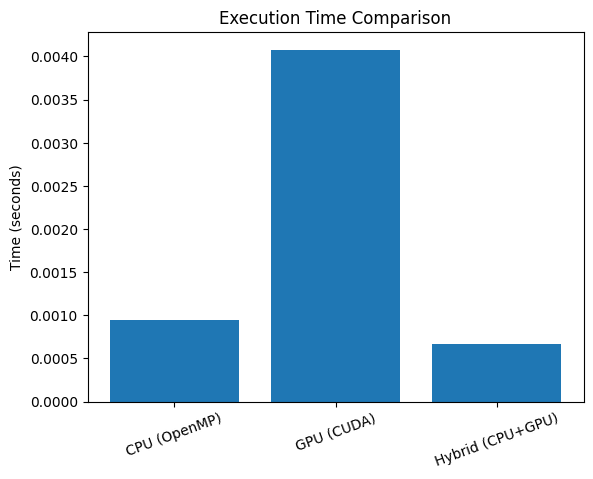

In [12]:
import matplotlib.pyplot as plt

modes = ["CPU (OpenMP)", "GPU (CUDA)", "Hybrid (CPU+GPU)"]
times = [0.00095, 0.00408, 0.000668]

plt.figure()
plt.bar(modes, times)

plt.title("Execution Time Comparison")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=20)

plt.show()

1. **Сравнение времени выполнения CPU, GPU и гибридного режима**

В ходе выполнения работы были реализованы три варианта обработки массива размером N=1000000:

*   обработка на CPU с использованием OpenMP
*   обработка на GPU с использованием CUDA
*   гибридная обработка, где первая половина массива выполнялась на CPU, а вторая на GPU одновременно

Полученные времена выполнения:

CPU (OpenMP):
t≈0.00095 сек

GPU (CUDA, общее время):
t≈0.00408 сек

Hybrid (CPU+GPU):
t≈0.00067 сек

Таким образом, наименьшее время выполнения было достигнуто в гибридном режиме.

2. Анализ производительности и эффективность гибридного подхода

Результаты показывают, что вычисления непосредственно на GPU выполняются очень быстро (ядро CUDA работало всего около 0.116 мс). Однако общее время GPU-обработки оказалось больше, чем у CPU, поскольку значительную часть времени занимают затраты на передачу данных между CPU и GPU (копирование Host → Device и обратно).

Гибридный подход оказался наиболее эффективным, так как вычисления выполнялись параллельно: CPU обрабатывал одну часть массива одновременно с GPU, что позволило уменьшить общее время выполнения. Итоговое время гибридной обработки определяется наиболее затратной частью вычислений и накладными расходами на передачу данных.

**Когда гибридный подход дает наибольший выигрыш**

Гибридная обработка обеспечивает максимальный прирост производительности в случаях, когда:

* задача достаточно большая по объёму данных

* вычисления на GPU значительно быстрее, чем на CPU

* CPU и GPU могут работать одновременно без простоя

* накладные расходы на копирование данных между устройствами относительно малы по сравнению с объёмом вычислений

Таким образом, гибридный подход наиболее выгоден для крупных вычислительно сложных задач, где можно эффективно распределить работу между CPU и GPU и минимизировать затраты на передачу данных.